In [1]:
import pandas as pd
import os
from pathlib import Path

# Load Abstracts and Topics Data
This notebook loads abstracts from files and retrieves work topics from the database.

In [2]:
# Path to pages folder
pages_folder = "pages"

# Create lists to store data
work_ids = []
abstracts = []

# Read all files from pages folder
for filename in os.listdir(pages_folder):
    if filename.endswith(".txt"):
        # Extract work_id from filename (remove 'abstract_' prefix and '.txt' suffix)
        work_id = filename.replace("abstract_", "").replace(".txt", "")
        
        # Read file content
        file_path = os.path.join(pages_folder, filename)
        with open(file_path, "r", encoding="utf-8") as f:
            abstract = f.read()
        
        work_ids.append(work_id)
        abstracts.append(abstract)

print(f"Loaded {len(work_ids)} abstracts")

Loaded 2339 abstracts


In [3]:
# Create DataFrame
df = pd.DataFrame({
    "work_id": work_ids,
    "abstract": abstracts
})

print(f"DataFrame shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

DataFrame shape: (2339, 2)

First few rows:


,work_id,abstract
0,W1058094418,Fourier transform infrared (FTIR) coupled to c...
1,W110766567,Digital Soil Mapping (DSM) can be defined as t...
2,W111526621,A paradox and a dilemmaThe student of rhetoric...
3,W1127371524,Background and aims Our objectives were to eva...
4,W1170969516,The interval neutrosophic uncertain linguistic...


In [4]:
# Display DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   work_id   2339 non-null   object
 1   abstract  2339 non-null   object
dtypes: object(2)
memory usage: 36.7+ KB


In [5]:
# Optional: Save DataFrame to CSV
df.to_csv("abstracts.csv", index=False, encoding="utf-8")
print("DataFrame saved to abstracts.csv")

DataFrame saved to abstracts.csv


## Part 2: Load Topics Data from Database

In [ ]:
import psycopg2


DB_HOST = "postgres.0ussama.dev"
DB_PORT = 5432
DB_NAME = "openalex_db"
DB_USER = "openalex_app"
DB_PASSWORD = '{yszMR*[v"T`,z#31aAe9z1%8'


try:
    connection = psycopg2.connect(
        host=DB_HOST,
        port=DB_PORT,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD,
        sslmode='require'
    )
    cursor = connection.cursor()
    print("Connected to PostgreSQL database successfully")
except Exception as e:
    print(f"Error connecting to database: {e}")
    exit()

Connected to PostgreSQL database successfully


In [ ]:
SQL_QUERY = "SELECT * FROM fact_work_topics"

try:
    cursor.execute(SQL_QUERY)
    results = cursor.fetchall()
    
    # Get column names
    column_names = [desc[0] for desc in cursor.description]
    
    print(f"Retrieved {len(results)} records from fact_work_topics")
    print(f"Columns: {column_names}")
except Exception as e:
    print(f"Error executing SQL query: {e}")
    cursor.close()
    connection.close()
    exit()

Retrieved 29350 records from fact_work_topics
Columns: ['fact_id', 'work_id', 'topic_id', 'topic_name', 'topic_score', 'domain_id', 'domain_name', 'field_id', 'field_name', 'subfield_id', 'subfield_name', 'created_at']


In [ ]:
df_topics = pd.DataFrame(results, columns=column_names)

print(f"Topics DataFrame shape: {df_topics.shape}")
print(f"\nFirst few rows:")
df_topics.head()

Topics DataFrame shape: (29350, 12)

First few rows:


,fact_id,work_id,topic_id,topic_name,topic_score,domain_id,domain_name,field_id,field_name,subfield_id,subfield_name,created_at
0,1,W2122910156,T10225,Essential Oils and Antimicrobial Activity,0.999899983406067,domains/1,Life Sciences,fields/11,Agricultural and Biological Sciences,subfields/1106,Food Science,2025-12-11 14:16:22.237464
1,2,W2122910156,T11613,Phytochemistry and Biological Activities,0.997200012207031,domains/1,Life Sciences,fields/11,Agricultural and Biological Sciences,subfields/1110,Plant Science,2025-12-11 14:16:22.240717
2,3,W2122910156,T10431,Ethnobotanical and Medicinal Plants Studies,0.996900022029877,domains/1,Life Sciences,fields/11,Agricultural and Biological Sciences,subfields/1110,Plant Science,2025-12-11 14:16:22.242732
3,4,W2185564569,T12167,Bacterial Identification and Susceptibility Te...,0.998499989509583,domains/1,Life Sciences,fields/13,"Biochemistry, Genetics and Molecular Biology",subfields/1308,Clinical Biochemistry,2025-12-11 14:16:22.246453
4,5,W2185564569,T10225,Essential Oils and Antimicrobial Activity,0.997900009155273,domains/1,Life Sciences,fields/11,Agricultural and Biological Sciences,subfields/1106,Food Science,2025-12-11 14:16:22.250263


In [9]:
# Display DataFrame info
df_topics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29350 entries, 0 to 29349
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   fact_id        29350 non-null  int64         
 1   work_id        29350 non-null  object        
 2   topic_id       29350 non-null  object        
 3   topic_name     29350 non-null  object        
 4   topic_score    29350 non-null  object        
 5   domain_id      29350 non-null  object        
 6   domain_name    29350 non-null  object        
 7   field_id       29350 non-null  object        
 8   field_name     29350 non-null  object        
 9   subfield_id    29350 non-null  object        
 10  subfield_name  29350 non-null  object        
 11  created_at     29350 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 2.7+ MB


In [ ]:
cursor.close()
connection.close()
print("Database connection closed")

Database connection closed


## Part 3: Merge Abstracts with Topics Data

In [ ]:
# Keep only the highest-scored topic for each work_id
df_topics_top = df_topics.loc[df_topics.groupby('work_id')['topic_score'].idxmax()]

print(f"Original topics rows: {len(df_topics)}")
print(f"Unique work_ids in topics: {df_topics['work_id'].nunique()}")
print(f"Top topics rows: {len(df_topics_top)}")

df_merged = df.merge(
    df_topics_top[['work_id', 'topic_name', 'topic_score', 'domain_name', 'field_name', 'subfield_name']],
    on='work_id',
    how='left'
)

print(f"\nMerged DataFrame shape: {df_merged.shape}")
print(f"Expected rows (abstracts): {len(df)}")
print(f"Actual rows: {len(df_merged)}")
print(f"\nFirst few rows:")
df_merged.head(10)

Original topics rows: 29350
Unique work_ids in topics: 10000
Top topics rows: 10000

Merged DataFrame shape: (2339, 7)
Expected rows (abstracts): 2339
Actual rows: 2339

First few rows:


,work_id,abstract,topic_name,topic_score,domain_name,field_name,subfield_name
0,W1058094418,Fourier transform infrared (FTIR) coupled to c...,Spectroscopy and Chemometric Analyses,0.999899983406067,Physical Sciences,Chemistry,Analytical Chemistry
1,W110766567,Digital Soil Mapping (DSM) can be defined as t...,Soil Geostatistics and Mapping,0.999899983406067,Physical Sciences,Environmental Science,Environmental Engineering
2,W111526621,A paradox and a dilemmaThe student of rhetoric...,Historical Linguistics and Language Studies,0.605000019073486,Social Sciences,Arts and Humanities,Language and Linguistics
3,W1127371524,Background and aims Our objectives were to eva...,Soil erosion and sediment transport,0.998399972915649,Life Sciences,Agricultural and Biological Sciences,Soil Science
4,W1170969516,The interval neutrosophic uncertain linguistic...,Multi-Criteria Decision Making,0.999700009822846,Social Sciences,Decision Sciences,Management Science and Operations Research
5,W1178499377,A new sensor based on carbon paste electrode m...,Electrochemical Analysis and Applications,1.000000000000000,Physical Sciences,Chemistry,Electrochemistry
6,W119905426,The Tnt1 transposable element of tobacco belon...,Plant Virus Research Studies,0.999599993228912,Life Sciences,Agricultural and Biological Sciences,Plant Science
7,W1225225733,Viticulture is a major worldwide economic sect...,Mycorrhizal Fungi and Plant Interactions,0.999800026416779,Life Sciences,Agricultural and Biological Sciences,Plant Science
8,W1239517042,We made an update of the intervarietal molecul...,Wheat and Barley Genetics and Pathology,0.999899983406067,Life Sciences,Agricultural and Biological Sciences,Plant Science
9,W12971209,The paper describes experiments on farmer part...,Agricultural pest management studies,0.998600006103516,Life Sciences,Agricultural and Biological Sciences,Plant Science


In [12]:
# Display column names and info of merged dataframe
print("Merged DataFrame columns:")
print(df_merged.columns.tolist())
print("\nMerged DataFrame info:")
df_merged.info()

Merged DataFrame columns:
['work_id', 'abstract', 'topic_name', 'topic_score', 'domain_name', 'field_name', 'subfield_name']

Merged DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   work_id        2339 non-null   object
 1   abstract       2339 non-null   object
 2   topic_name     2339 non-null   object
 3   topic_score    2339 non-null   object
 4   domain_name    2339 non-null   object
 5   field_name     2339 non-null   object
 6   subfield_name  2339 non-null   object
dtypes: object(7)
memory usage: 128.0+ KB


In [13]:
# Check for null values
print("Null values in merged DataFrame:")
print(df_merged.isnull().sum())
print(f"\nDataFrame summary:")
print(df_merged.describe(include='all'))

Null values in merged DataFrame:
work_id          0
abstract         0
topic_name       0
topic_score      0
domain_name      0
field_name       0
subfield_name    0
dtype: int64

DataFrame summary:
            work_id                                           abstract  \
count          2339                                               2339   
unique         2339                                               2338   
top     W1058094418  Abstract An abstract is not available for this...   
freq              1                                                  2   

                                               topic_name        topic_score  \
count                                                2339               2339   
unique                                                826                222   
top     Particle physics theoretical and experimental ...  1.000000000000000   
freq                                                   87                554   

              domain_name    

In [14]:
# Save the merged dataframe to CSV
df_merged.to_csv("abstracts_with_topics.csv", index=False, encoding="utf-8")
print("Merged DataFrame saved to abstracts_with_topics.csv")

Merged DataFrame saved to abstracts_with_topics.csv


## Part 4: Simple Embedding + scikit-learn Classification
Embed abstracts using Word2Vec and classify into topic names

In [ ]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

df_train = df_merged.dropna(subset=['abstract', 'topic_name']).copy()

print(f"Training data size: {len(df_train)} records")
print(f"Unique topics: {df_train['topic_name'].nunique()}")
print(f"\nTopic distribution:")
print(df_train['topic_name'].value_counts())

Training data size: 2339 records
Unique topics: 826

Topic distribution:
topic_name
Particle physics theoretical and experimental studies    87
Corrosion Behavior and Inhibition                        53
Adsorption and biosorption for pollutant removal         39
Perovskite Materials and Applications                    33
Wheat and Barley Genetics and Pathology                  28
                                                         ..
Precipitation Measurement and Analysis                    1
2D Materials and Applications                             1
Islamic Finance and Banking Studies                       1
Hepatitis B Virus Studies                                 1
History and advancements in chemistry                     1
Name: count, Length: 826, dtype: int64


In [ ]:
def preprocess_text(text):
    """Simple text preprocessing"""
    # Convert to lowercase and split into words
    words = text.lower().split()
    # Remove very short words
    words = [w for w in words if len(w) > 2]
    return words

# Tokenize all abstracts
print("Preprocessing abstracts...")
tokenized_abstracts = df_train['abstract'].apply(preprocess_text).tolist()

print(f" Tokenized {len(tokenized_abstracts)} abstracts")
print(f"Example tokens from first abstract: {tokenized_abstracts[0][:10]}")

Preprocessing abstracts...
✅ Tokenized 2339 abstracts
Example tokens from first abstract: ['fourier', 'transform', 'infrared', '(ftir)', 'coupled', 'chemometrics', 'was', 'shown', 'useful', 'method']


In [ ]:
print("Training Doc2Vec embeddings...")

# Create tagged documents (each abstract gets a unique tag)
tagged_data = [TaggedDocument(words=tokens, tags=[str(i)]) for i, tokens in enumerate(tokenized_abstracts)]

# Train Doc2Vec model
doc2vec_model = Doc2Vec(
    vector_size=100,           # Dimension of embedding vectors
    min_count=2,               # Ignore words appearing less than 2 times
    epochs=40,                 # Training epochs (more epochs for Doc2Vec)
    workers=4,                 # Number of threads
    dm=1,                      # Use DM (Distributed Memory) - similar to Word2Vec
    window=5                   # Context window size
)

print("Building vocabulary...")
doc2vec_model.build_vocab(tagged_data)

print("Training model...")
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

print(f" Doc2Vec model trained!")
print(f"Vector size: {doc2vec_model.vector_size}")
print(f"\nExample: Vector for first abstract:")
print(f"  {doc2vec_model.infer_vector(tokenized_abstracts[0])[:5]}... (showing first 5 dimensions)")

Training Doc2Vec embeddings...
Building vocabulary...
Training model...
✅ Doc2Vec model trained!
Vector size: 100

Example: Vector for first abstract:
  [-1.277224   -0.1286635  -0.5893883   1.5349069  -0.42544526]... (showing first 5 dimensions)


In [ ]:
print("Converting abstracts to Doc2Vec vectors...")
print(f"Number of tokenized abstracts: {len(tokenized_abstracts)}")
print(f"Number of df_train rows: {len(df_train)}")

# Ensure tokenized_abstracts matches df_train
if len(tokenized_abstracts) != len(df_train):
    print(f"  MISMATCH DETECTED: Retokenizing all abstracts from df_train...")
    tokenized_abstracts = df_train['abstract'].apply(preprocess_text).tolist()
    print(f" Retokenized {len(tokenized_abstracts)} abstracts")

X = np.array([doc2vec_model.infer_vector(tokens) for tokens in tokenized_abstracts])

print(f" Created Doc2Vec embedding vectors!")
print(f"Shape of X: {X.shape}  (samples, dimensions)")
print(f"Example vector (first abstract): {X[0][:5]}... (showing first 5 dimensions)")



# Create column names for the embedding dimensions
embedding_columns = [f"embedding_{i}" for i in range(X.shape[1])]

# Create dataframe with embeddings and work_ids
df_embeddings = pd.DataFrame(X, columns=embedding_columns)
df_embeddings.insert(0, 'work_id', df_train['work_id'].values)
df_embeddings.insert(1, 'topic_name', df_train['topic_name'].values)

print(f"\n Created embeddings dataframe!")
print(f"Embeddings dataframe shape: {df_embeddings.shape}")
print(f"Columns: {df_embeddings.columns.tolist()[:5]}... (showing first 5)")

# Save embeddings to CSV
df_embeddings.to_csv("abstracts_embeddings.csv", index=False, encoding="utf-8")
print("\n Saved embeddings to: abstracts_embeddings.csv")
print(f"File contains {len(df_embeddings)} rows and {len(df_embeddings.columns)} columns")

# Display sample
print("\nSample of embeddings dataframe:")
print(df_embeddings.iloc[:3, :5].to_string())

Converting abstracts to Doc2Vec vectors...
Number of tokenized abstracts: 2339
Number of df_train rows: 2339
✅ Created Doc2Vec embedding vectors!
Shape of X: (2339, 100)  (samples, dimensions)
Example vector (first abstract): [-1.1535126  -0.07473846 -0.40003932  1.2871236  -0.4172688 ]... (showing first 5 dimensions)

✅ Created embeddings dataframe!
Embeddings dataframe shape: (2339, 102)
Columns: ['work_id', 'topic_name', 'embedding_0', 'embedding_1', 'embedding_2']... (showing first 5)

✅ Saved embeddings to: abstracts_embeddings.csv
File contains 2339 rows and 102 columns

Sample of embeddings dataframe:
       work_id                                   topic_name  embedding_0  embedding_1  embedding_2
0  W1058094418        Spectroscopy and Chemometric Analyses    -1.153513    -0.074738    -0.400039
1   W110766567               Soil Geostatistics and Mapping     0.532952    -0.060905     0.066783
2   W111526621  Historical Linguistics and Language Studies    -1.192221     0.626888  

In [ ]:

# Encode topic names to numeric labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_train['topic_name'])

print(f" Topic classes: {len(label_encoder.classes_)}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Count samples per class
topic_counts = pd.Series(y).value_counts().sort_index()
print(f"\n Class Distribution (all {len(label_encoder.classes_)} classes):")
print(f"Min samples per class: {topic_counts.min()}")
print(f"Max samples per class: {topic_counts.max()}")
print(f"Mean samples per class: {topic_counts.mean():.1f}")

print(f"\nClasses with only 1-2 samples (minority classes):")
minority = topic_counts[topic_counts <= 2]
if len(minority) > 0:
    for idx, count in minority.items():
        print(f"  {label_encoder.classes_[idx]:40} ({count} sample(s))")
else:
    print("  None - all classes have at least 3 samples!")

#  NO FILTERING - We keep all samples including minority classes
print(f"\n TOTAL SAMPLES TO USE: {len(y)} (100% of data)")
print(f" TOTAL CLASSES: {len(np.unique(y))}")

✅ Topic classes: 826
X shape: (2339, 100)
y shape: (2339,)

📊 Class Distribution (all 826 classes):
Min samples per class: 1
Max samples per class: 87
Mean samples per class: 2.8

Classes with only 1-2 samples (minority classes):
  2D Materials and Applications            (1 sample(s))
  3D Printing in Biomedical Research       (1 sample(s))
  AI in Service Interactions               (1 sample(s))
  Academic and Historical Perspectives in Psychology (1 sample(s))
  Acoustic Wave Phenomena Research         (2 sample(s))
  Action Observation and Synchronization   (1 sample(s))
  Acute Lymphoblastic Leukemia research    (1 sample(s))
  Adenosine and Purinergic Signaling       (1 sample(s))
  Adipokines, Inflammation, and Metabolic Diseases (1 sample(s))
  Adipose Tissue and Metabolism            (2 sample(s))
  Adolescent and Pediatric Healthcare      (1 sample(s))
  Advanced Battery Materials and Technologies (1 sample(s))
  Advanced Chemical Sensor Technologies    (2 sample(s))
  Advanc

In [ ]:

# Simple 80/20 split (no stratification needed for hyperparameter tuning)
# We want to keep ALL samples including minority classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=None  # Simple split - no stratification
)

print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of unique classes: {len(np.unique(y))}")
print(f"\n Data split successfully - keeping all {len(y)} samples!")

Training set: 1871 samples (80.0%)
Test set: 468 samples (20.0%)
Training set shape: (1871, 100)
Test set shape: (468, 100)
Number of unique classes: 826

✅ Data split successfully - keeping all 2339 samples!


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.linear_model import SGDClassifier
import time
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("FAST HYPERPARAMETER TUNING (All 2339 samples)")
print("="*70)
print(f"\n Dataset Summary:")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")
print(f"   Features: {X_train.shape[1]}")
print(f"   Classes: {len(np.unique(y))}")
print(f"   Including minority classes with 1-2 samples\n")

# Start timer
start_time = time.time()


# Regular KFold works with any class distribution
kf = KFold(n_splits=2, shuffle=True, random_state=42)


print("1- Random Forest (RandomizedSearchCV, 8 iterations x 2 folds = 16 fits)")
print("   Estimated time: 2-3 minutes\n")

rf_param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [15, 20, 25, 30],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [2, 3, 4]
}

rf_grid = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=1),
    rf_param_dist,
    n_iter=8,  # Test only 8 random combinations
    cv=kf,
    scoring='accuracy',
    n_jobs=1,
    verbose=0,
    random_state=42
)
rf_grid.fit(X_train, y_train)
rf_model = rf_grid.best_estimator_
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print(f"    Best Params: {rf_grid.best_params_}")
print(f"    CV Accuracy: {rf_grid.best_score_:.4f}")
print(f"    Test Accuracy: {rf_accuracy:.4f}\n")


print("2- Logistic Regression (RandomizedSearchCV, 6 iterations x 2 folds = 12 fits)")
print("   Estimated time: 30 seconds\n")

lr_param_dist = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [300, 500, 1000],
    'penalty': ['l2']
}

lr_grid = RandomizedSearchCV(
    LogisticRegression(random_state=42, solver='lbfgs', n_jobs=1, max_iter=1000),
    lr_param_dist,
    n_iter=6,  # Test only 6 random combinations
    cv=kf,
    scoring='accuracy',
    n_jobs=1,
    verbose=0,
    random_state=42
)
lr_grid.fit(X_train, y_train)
lr_model = lr_grid.best_estimator_
lr_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)

print(f"    Best Params: {lr_grid.best_params_}")
print(f"    CV Accuracy: {lr_grid.best_score_:.4f}")
print(f"    Test Accuracy: {lr_accuracy:.4f}\n")


print("3- SVM (SGDClassifier, RandomizedSearchCV, 6 iterations x 2 folds = 12 fits)")
print("   Estimated time: 30 seconds\n")

svm_param_dist = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01],
    'max_iter': [300, 500, 1000],
    'loss': ['hinge']
}

svm_grid = RandomizedSearchCV(
    SGDClassifier(random_state=42, n_jobs=1),
    svm_param_dist,
    n_iter=6,
    cv=kf,
    scoring='accuracy',
    n_jobs=1,
    verbose=0,
    random_state=42
)
svm_grid.fit(X_train, y_train)
svm_model = svm_grid.best_estimator_
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)

print(f"    Best Params: {svm_grid.best_params_}")
print(f"    CV Accuracy: {svm_grid.best_score_:.4f}")
print(f"    Test Accuracy: {svm_accuracy:.4f}\n")

# ============ TIMER ============
elapsed = time.time() - start_time
print(f"  TOTAL TIME: {elapsed:.1f} seconds ({elapsed/60:.2f} minutes)")
print(f"   Total model fits: 16 + 12 + 12 = 40 fits")
print(f"   All samples used (including minority classes)\n")

print("="*70)
print(" Hyperparameter tuning completed!")
print("="*70)

FAST HYPERPARAMETER TUNING (All 2339 samples)

📊 Dataset Summary:
   Training samples: 1871
   Test samples: 468
   Features: 100
   Classes: 826
   Including minority classes with 1-2 samples

1️⃣ Random Forest (RandomizedSearchCV, 8 iterations × 2 folds = 16 fits)
   Estimated time: 2-3 minutes

   ✅ Best Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30}
   ✅ CV Accuracy: 0.1475
   ✅ Test Accuracy: 0.1496

2️⃣ Logistic Regression (RandomizedSearchCV, 6 iterations × 2 folds = 12 fits)
   Estimated time: 30 seconds

   ✅ Best Params: {'penalty': 'l2', 'max_iter': 1000, 'C': 1}
   ✅ CV Accuracy: 0.2085
   ✅ Test Accuracy: 0.2265

3️⃣ SVM (SGDClassifier, RandomizedSearchCV, 6 iterations × 2 folds = 12 fits)
   Estimated time: 30 seconds

   ✅ Best Params: {'max_iter': 500, 'loss': 'hinge', 'alpha': 0.01}
   ✅ CV Accuracy: 0.1860
   ✅ Test Accuracy: 0.1966

⏱️  TOTAL TIME: 541.2 seconds (9.02 minutes)
   Total model fits: 16 + 12 + 12 = 40 fits


In [ ]:


print("="*70)
print("MODEL COMPARISON")
print("="*70)

models_performance = [
    ("Random Forest", rf_accuracy, rf_model, rf_pred),
    ("Logistic Regression", lr_accuracy, lr_model, lr_pred),
    ("SVM (SGDClassifier)", svm_accuracy, svm_model, svm_pred)
]

# Sort by accuracy (descending)
models_performance_sorted = sorted(models_performance, key=lambda x: x[1], reverse=True)

print("\n Model Rankings by Test Accuracy:")
for rank, (name, acc, _, _) in enumerate(models_performance_sorted, 1):
    print(f"{rank}. {name:30} {acc:6.2%}")

# Select best model
best_model_name, best_accuracy, best_model, best_pred = models_performance_sorted[0]

print(f"\n BEST MODEL: {best_model_name}")
print(f"Test Accuracy: {best_accuracy:.2%}")
print("="*70)

MODEL COMPARISON

🏆 Model Rankings by Test Accuracy:
1. Logistic Regression            22.65%
2. SVM (SGDClassifier)            19.66%
3. Random Forest                  14.96%

✨ BEST MODEL: Logistic Regression
Test Accuracy: 22.65%


In [ ]:


from sklearn.model_selection import cross_val_score, KFold

print("\n" + "="*70)
print("CROSS-VALIDATION ANALYSIS (2-Fold)")
print("="*70)

# Use same 2-fold KFold for consistency (no stratification needed)
kf_cv = KFold(n_splits=2, shuffle=True, random_state=42)

for model_name, model in [("Random Forest", rf_model), ("Logistic Regression", lr_model), ("SVM (SGD)", svm_model)]:
    print(f"\n{model_name}:")
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf_cv, scoring='accuracy', n_jobs=1)
    print(f"  Fold Scores: {[f'{score:.4f}' for score in cv_scores]}")
    print(f"  Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Test Accuracy:    {accuracy_score(y_test, model.predict(X_test)):.4f}")


CROSS-VALIDATION ANALYSIS (2-Fold)

Random Forest:
  Fold Scores: ['0.1442', '0.1508']
  Mean CV Accuracy: 0.1475 (+/- 0.0033)
  Test Accuracy:    0.1496

Logistic Regression:
  Fold Scores: ['0.1976', '0.2193']
  Mean CV Accuracy: 0.2085 (+/- 0.0108)
  Test Accuracy:    0.2265

SVM (SGD):
  Fold Scores: ['0.1891', '0.1829']
  Mean CV Accuracy: 0.1860 (+/- 0.0031)
  Test Accuracy:    0.1966


In [ ]:


print("\n" + "="*70)
print(f"DETAILED EVALUATION - {best_model_name}")
print("="*70)

# Get predictions on test set
y_pred_best = best_model.predict(X_test)

print("\nClassification Report:\n")
# Method 1: Only report on classes that appear in test set (cleaner output)
print(classification_report(y_test, y_pred_best))

print("\n" + "="*70)
print("Per-Class Performance (Top 20 classes by frequency):")
print("="*70)

# Get the classes that appear in the test set
unique_test_classes = np.unique(y_test)
print(f"\nNumber of classes in test set: {len(unique_test_classes)} out of {len(label_encoder.classes_)}")
print(f"Total test samples: {len(y_test)}")

# Generate report for classes in test set
print("\nDetailed Classification Report (for classes present in test set):\n")
print(classification_report(
    y_test, 
    y_pred_best, 
    target_names=[label_encoder.classes_[i] for i in unique_test_classes],
    labels=unique_test_classes
))

print("\nConfusion Matrix (Sample - showing first 10x10):")
cm = confusion_matrix(y_test, y_pred_best)
print(cm[:10, :10])

print(f"\nFull Confusion Matrix Shape: {cm.shape}")
print(f"Total Test Samples: {len(y_test)}")
print(f"Classes that predicted: {len(np.unique(y_pred_best))}")
print(f"Classes in test set: {len(np.unique(y_test))}")


DETAILED EVALUATION - Logistic Regression

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.50      1.00      0.67         1
           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         1
          14       0.58      0.88      0.70         8
          16       0.67      0.80      0.73         5
          17       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         0
          28       0.00      0.00      0.00         1
          31       0.00      0.00      0.00         1
          34       0.00      0.00      0.00         1
          35 

In [ ]:


from sklearn.metrics import precision_recall_fscore_support

# Get best model predictions
y_pred_best = best_model.predict(X_test)

# Calculate weighted average metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_best, average='weighted'
)

# Calculate macro average metrics (unweighted)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred_best, average='macro'
)

print("\n" + "="*70)
print("DETAILED PERFORMANCE METRICS")
print("="*70)

print(f"\n OVERALL ACCURACY: {accuracy_score(y_test, y_pred_best):.4f} ({accuracy_score(y_test, y_pred_best)*100:.2f}%)")

print(f"\n WEIGHTED AVERAGE (accounts for class imbalance):")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")

print(f"\n MACRO AVERAGE (equal weight per class):")
print(f"   Precision: {precision_macro:.4f}")
print(f"   Recall:    {recall_macro:.4f}")
print(f"   F1-Score:  {f1_macro:.4f}")

print(f"\n Model Type: {type(best_model).__name__}")
print("="*70)


DETAILED PERFORMANCE METRICS

🎯 OVERALL ACCURACY: 0.2265 (22.65%)

📊 WEIGHTED AVERAGE (accounts for class imbalance):
   Precision: 0.1622
   Recall:    0.2265
   F1-Score:  0.1745

📊 MACRO AVERAGE (equal weight per class):
   Precision: 0.0677
   Recall:    0.0994
   F1-Score:  0.0725

📈 Model Type: LogisticRegression


In [ ]:

print("\n" + "="*70)
print("CLASSIFYING ALL ABSTRACTS")
print("="*70)

print(f"\nUsing best model: {best_model_name}\n")

# Predict using the best model on ALL dataset (not just training)
all_predictions = best_model.predict(X)

# Convert predictions to topic names
predicted_topics = label_encoder.inverse_transform(all_predictions)

# Create results dataframe with predictions
# Use df_train (not df_train_filtered, which doesn't exist)
df_results = df_train.copy()
df_results['predicted_topic'] = predicted_topics

# Reset index to ensure alignment
df_results = df_results.reset_index(drop=True)

# Calculate accuracy on full dataset
accuracy = (df_results['topic_name'] == df_results['predicted_topic']).sum() / len(df_results)

print(f" Classified {len(df_results)} abstracts")
print(f"Overall Accuracy on Dataset: {accuracy:.2%}\n")

# Show sample predictions
print(" Sample Predictions (first 15):")
print(df_results[['work_id', 'topic_name', 'predicted_topic']].head(15).to_string())

# Show prediction statistics
print("\n Prediction Statistics:")
correct = (df_results['topic_name'] == df_results['predicted_topic']).sum()
incorrect = len(df_results) - correct
print(f"   Correct:   {correct:,} ({correct/len(df_results)*100:.1f}%)")
print(f"   Incorrect: {incorrect:,} ({incorrect/len(df_results)*100:.1f}%)")


CLASSIFYING ALL ABSTRACTS

Using best model: Logistic Regression

✅ Classified 2339 abstracts
Overall Accuracy on Dataset: 84.31%

📋 Sample Predictions (first 15):
        work_id                                     topic_name                                predicted_topic
0   W1058094418          Spectroscopy and Chemometric Analyses          Spectroscopy and Chemometric Analyses
1    W110766567                 Soil Geostatistics and Mapping                 Soil Geostatistics and Mapping
2    W111526621    Historical Linguistics and Language Studies    Historical Linguistics and Language Studies
3   W1127371524            Soil erosion and sediment transport            Soil erosion and sediment transport
4   W1170969516                 Multi-Criteria Decision Making                 Multi-Criteria Decision Making
5   W1178499377      Electrochemical Analysis and Applications      Electrochemical Analysis and Applications
6    W119905426                   Plant Virus Research Studies   

In [ ]:


print("\n" + "="*70)
print("SAVING CLASSIFICATION RESULTS")
print("="*70 + "\n")

# Save complete results with predictions
results_df = df_results[['work_id', 'abstract', 'topic_name', 'predicted_topic']].copy()
results_df.to_csv("classification_results_optimized.csv", index=False, encoding="utf-8")

print(f" Results saved to: classification_results_optimized.csv")
print(f"   - Total records: {len(results_df):,}")
print(f"   - Columns: {list(results_df.columns)}")

# Save summary statistics
summary_stats = {
    'Total Abstracts': len(results_df),
    'Correct Predictions': correct,
    'Incorrect Predictions': incorrect,
    'Accuracy (%)': f"{accuracy*100:.2f}",
    'Model Used': best_model_name,
    'Embedding Dimension': X_train.shape[1],
    'Number of Classes': len(np.unique(y)),
    'Training Samples': len(X_train),
    'Test Samples': len(X_test)
}

print(f"\n Summary Statistics:")
for key, value in summary_stats.items():
    print(f"   {key}: {value}")

print("\n Classification pipeline completed successfully!")


SAVING CLASSIFICATION RESULTS

✅ Results saved to: classification_results_optimized.csv
   - Total records: 2,339
   - Columns: ['work_id', 'abstract', 'topic_name', 'predicted_topic']

📊 Summary Statistics:
   Total Abstracts: 2339
   Correct Predictions: 1972
   Incorrect Predictions: 367
   Accuracy (%): 84.31
   Model Used: Logistic Regression
   Embedding Dimension: 100
   Number of Classes: 826
   Training Samples: 1871
   Test Samples: 468

✨ Classification pipeline completed successfully!


In [ ]:


import joblib

print("\n" + "="*70)
print("SAVING TRAINED MODELS")
print("="*70 + "\n")

# Save the best model
model_filename = f"topic_classifier_{best_model_name.replace(' ', '_').lower()}.pkl"
joblib.dump(best_model, model_filename)
print(f" Saved best model: {model_filename}")
print(f"   Model type: {type(best_model).__name__}")
print(f"   Accuracy on test set: {best_accuracy:.2%}")

# Save Doc2Vec model
doc2vec_filename = 'doc2vec_embeddings_model.model'
doc2vec_model.save(doc2vec_filename)
print(f" Saved Doc2Vec embeddings: {doc2vec_filename}")
print(f"   Embedding dimension: {doc2vec_model.vector_size}")

# Save label encoder
encoder_filename = 'label_encoder.pkl'
joblib.dump(label_encoder, encoder_filename)
print(f" Saved label encoder: {encoder_filename}")
print(f"   Number of classes: {len(label_encoder.classes_)}")

# Save preprocessing function
preprocessing_info = {
    'vector_size': doc2vec_model.vector_size,
    'n_classes': len(label_encoder.classes_),
    'accuracy': best_accuracy,
    'total_samples_trained': len(df_train),
    'model_type': best_model_name
}

import json
with open('model_metadata.json', 'w') as f:
    json.dump(preprocessing_info, f, indent=2)
print(f" Saved model metadata: model_metadata.json")

# Save all 3 models for reference
print(f"\n Also saving alternative models for reference:")
joblib.dump(rf_model, 'model_random_forest.pkl')
print(f" Saved: model_random_forest.pkl (Accuracy: {rf_accuracy:.2%})")
joblib.dump(lr_model, 'model_logistic_regression.pkl')
print(f" Saved: model_logistic_regression.pkl (Accuracy: {lr_accuracy:.2%})")
joblib.dump(svm_model, 'model_svm_sgd.pkl')
print(f" Saved: model_svm_sgd.pkl (Accuracy: {svm_accuracy:.2%})")

print(" ALL MODELS SAVED SUCCESSFULLY!")
print("="*70)


SAVING TRAINED MODELS

✅ Saved best model: topic_classifier_logistic_regression.pkl
   Model type: LogisticRegression
   Accuracy on test set: 22.65%
✅ Saved Doc2Vec embeddings: doc2vec_embeddings_model.model
   Embedding dimension: 100
✅ Saved label encoder: label_encoder.pkl
   Number of classes: 826
✅ Saved model metadata: model_metadata.json

📚 Also saving alternative models for reference:
✅ Saved: model_random_forest.pkl (Accuracy: 14.96%)
✅ Saved: model_logistic_regression.pkl (Accuracy: 22.65%)
✅ Saved: model_svm_sgd.pkl (Accuracy: 19.66%)
✨ ALL MODELS SAVED SUCCESSFULLY!


In [ ]:


print("\n" + "="*70)
print("TRAINING IMPROVED DOC2VEC MODEL (V2)")
print("="*70 + "\n")

#  Use existing tokenized_abstracts (already preprocessed)
print(f"Using {len(tokenized_abstracts)} tokenized abstracts")

# Create tagged documents
tagged_data_v2 = [TaggedDocument(words=tokens, tags=[str(i)]) for i, tokens in enumerate(tokenized_abstracts)]

# Train improved Doc2Vec model
doc2vec_model_v2 = Doc2Vec(
    vector_size=200,           #  Increased from 100
    min_count=5,               #  Increased from 2 (remove noise)
    epochs=100,                #  Increased from 40 (more training)
    workers=4,
    dm=1,
    window=10,                 #  Increased from 5 (larger context)
    alpha=0.025,
    min_alpha=0.0001,
    seed=42
)

print("Building vocabulary (V2)...")
doc2vec_model_v2.build_vocab(tagged_data_v2)

print("Training improved model (this may take 2-3 minutes)...")
doc2vec_model_v2.train(tagged_data_v2, total_examples=doc2vec_model_v2.corpus_count, epochs=doc2vec_model_v2.epochs)

print(f"✅ Improved Doc2Vec model trained!")
print(f"   Vector size: {doc2vec_model_v2.vector_size}")
print(f"   Epochs: {doc2vec_model_v2.epochs}")
print(f"   Vocabulary size: {len(doc2vec_model_v2.wv)}")

# Create new embeddings with improved model
print("\nCreating embeddings with improved Doc2Vec model...")
X_v2 = np.array([doc2vec_model_v2.infer_vector(tokens) for tokens in tokenized_abstracts])

print(f"✅ New embeddings created!")
print(f"   Shape: {X_v2.shape}")
print(f"   Vector size: {X_v2.shape[1]} (increased from {X.shape[1]})")

# Compare embeddings
print(f"\n📊 Comparison:")
print(f"   Original embeddings: {X.shape}")
print(f"   Improved embeddings: {X_v2.shape}")


TRAINING IMPROVED DOC2VEC MODEL (V2)

Using 2339 tokenized abstracts
Building vocabulary (V2)...
Training improved model (this may take 2-3 minutes)...
✅ Improved Doc2Vec model trained!
   Vector size: 200
   Epochs: 100
   Vocabulary size: 9064

Creating embeddings with improved Doc2Vec model...
✅ New embeddings created!
   Shape: (2339, 200)
   Vector size: 200 (increased from 100)

📊 Comparison:
   Original embeddings: (2339, 100)
   Improved embeddings: (2339, 200)


In [ ]:


print("\n" + "="*70)
print("FILTERING MINORITY CLASSES")
print("="*70)

# Get topic counts
topic_counts = df_train['topic_name'].value_counts()

# Try different minimum sample thresholds
thresholds = [3, 5, 10]

print(f"\nOriginal dataset:")
print(f"   Total samples: {len(df_train)}")
print(f"   Total topics: {df_train['topic_name'].nunique()}")  
print(f"   Min samples per topic: {topic_counts.min()}")
print(f"   Max samples per topic: {topic_counts.max()}")
print(f"   Mean samples per topic: {topic_counts.mean():.1f}")

print(f"\n Impact of different thresholds:")
for threshold in thresholds:
    valid_topics = topic_counts[topic_counts >= threshold].index
    filtered_size = len(df_train[df_train['topic_name'].isin(valid_topics)])
    filtered_classes = len(valid_topics)
    
    print(f"\n   Threshold = {threshold} samples:")
    print(f"      Remaining samples: {filtered_size} ({filtered_size/len(df_train)*100:.1f}%)")
    print(f"      Remaining topics: {filtered_classes} ({filtered_classes/df_train['topic_name'].nunique()*100:.1f}%)")  # ✅ FIXED
    print(f"      Topics removed: {df_train['topic_name'].nunique() - filtered_classes}")  

#  Choose threshold = 5 (good balance)
MIN_SAMPLES = 5
valid_topics_filtered = topic_counts[topic_counts >= MIN_SAMPLES].index

# Create filtered dataset
df_train_filtered = df_train[df_train['topic_name'].isin(valid_topics_filtered)].copy()
tokenized_abstracts_filtered = df_train_filtered['abstract'].apply(preprocess_text).tolist()

print(f"\n Using threshold = {MIN_SAMPLES}")
print(f"   Filtered samples: {len(df_train_filtered)}")
print(f"   Filtered topics: {df_train_filtered['topic_name'].nunique()}")  

# Create embeddings with improved Doc2Vec (V2) on filtered data
print("\nCreating embeddings for filtered dataset...")
X_filtered = np.array([doc2vec_model_v2.infer_vector(tokens) for tokens in tokenized_abstracts_filtered])

# Encode labels
label_encoder_filtered = LabelEncoder()
y_filtered = label_encoder_filtered.fit_transform(df_train_filtered['topic_name'])

print(f" Filtered embeddings created!")
print(f"   X_filtered shape: {X_filtered.shape}")
print(f"   y_filtered shape: {y_filtered.shape}")
print(f"   Classes: {len(label_encoder_filtered.classes_)}")


FILTERING MINORITY CLASSES

Original dataset:
   Total samples: 2339
   Total topics: 826
   Min samples per topic: 1
   Max samples per topic: 87
   Mean samples per topic: 2.8

📊 Impact of different thresholds:

   Threshold = 3 samples:
      Remaining samples: 1566 (67.0%)
      Remaining topics: 227 (27.5%)
      Topics removed: 599

   Threshold = 5 samples:
      Remaining samples: 1170 (50.0%)
      Remaining topics: 110 (13.3%)
      Topics removed: 716

   Threshold = 10 samples:
      Remaining samples: 712 (30.4%)
      Remaining topics: 38 (4.6%)
      Topics removed: 788

✅ Using threshold = 5
   Filtered samples: 1170
   Filtered topics: 110

Creating embeddings for filtered dataset...
✅ Filtered embeddings created!
   X_filtered shape: (1170, 200)
   y_filtered shape: (1170,)
   Classes: 110


In [ ]:
# 

print("\n" + "="*70)
print("HYPERPARAMETER TUNING - IMPROVED APPROACH")
print("="*70)
print(f"\n Dataset Summary:")
print(f"   Training samples: {len(df_train_filtered)} (filtered)")
print(f"   Topics: {len(label_encoder_filtered.classes_)}")
print(f"   Features: {X_filtered.shape[1]} (improved embeddings)\n")

# Split filtered data
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(
    X_filtered, y_filtered,
    test_size=0.2,
    random_state=42,
    stratify=None
)

print(f"Train/Test split:")
print(f"   Training: {len(X_train_v2)} samples")
print(f"   Test: {len(X_test_v2)} samples\n")

# Start timer
start_time = time.time()

kf_v2 = KFold(n_splits=2, shuffle=True, random_state=42)


print("1- Random Forest (Improved regularization)")
print("   Training...\n")

rf_param_dist_v2 = {
    'n_estimators': [150, 200, 250],
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [5, 7, 10],
    'max_features': ['sqrt', 'log2']
}

rf_grid_v2 = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=1, class_weight='balanced'),
    rf_param_dist_v2,
    n_iter=10,
    cv=kf_v2,
    scoring='accuracy',
    n_jobs=1,
    verbose=0,
    random_state=42
)
rf_grid_v2.fit(X_train_v2, y_train_v2)
rf_model_v2 = rf_grid_v2.best_estimator_
rf_pred_v2 = rf_model_v2.predict(X_test_v2)
rf_accuracy_v2 = accuracy_score(y_test_v2, rf_pred_v2)

print(f"    Test Accuracy: {rf_accuracy_v2:.4f} ({rf_accuracy_v2*100:.2f}%)\n")


print("2- Logistic Regression (Stronger regularization)")
print("   Training...\n")

lr_param_dist_v2 = {
    'C': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [1000, 2000, 5000],
    'penalty': ['l2']
}

lr_grid_v2 = RandomizedSearchCV(
    LogisticRegression(
        random_state=42, 
        solver='lbfgs', 
        n_jobs=1, 
        max_iter=2000,
        class_weight='balanced'
    ),
    lr_param_dist_v2,
    n_iter=8,
    cv=kf_v2,
    scoring='accuracy',
    n_jobs=1,
    verbose=0,
    random_state=42
)
lr_grid_v2.fit(X_train_v2, y_train_v2)
lr_model_v2 = lr_grid_v2.best_estimator_
lr_pred_v2 = lr_model_v2.predict(X_test_v2)
lr_accuracy_v2 = accuracy_score(y_test_v2, lr_pred_v2)

print(f"    Test Accuracy: {lr_accuracy_v2:.4f} ({lr_accuracy_v2*100:.2f}%)\n")


print("3- SVM (Better regularization)")
print("   Training...\n")

svm_param_dist_v2 = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [1000, 2000, 5000],
    'loss': ['hinge', 'squared_hinge'],
    'penalty': ['l2']
}

svm_grid_v2 = RandomizedSearchCV(
    SGDClassifier(random_state=42, n_jobs=1, class_weight='balanced', tol=0.001),
    svm_param_dist_v2,
    n_iter=8,
    cv=kf_v2,
    scoring='accuracy',
    n_jobs=1,
    verbose=0,
    random_state=42
)
svm_grid_v2.fit(X_train_v2, y_train_v2)
svm_model_v2 = svm_grid_v2.best_estimator_
svm_pred_v2 = svm_model_v2.predict(X_test_v2)
svm_accuracy_v2 = accuracy_score(y_test_v2, svm_pred_v2)

print(f"    Test Accuracy: {svm_accuracy_v2:.4f} ({svm_accuracy_v2*100:.2f}%)\n")

elapsed = time.time() - start_time
print(f"  Total training time: {elapsed:.1f} seconds ({elapsed/60:.2f} minutes)")

print("\n" + "="*70)
print(" Improved hyperparameter tuning completed!")
print("="*70)


HYPERPARAMETER TUNING - IMPROVED APPROACH

📊 Dataset Summary:
   Training samples: 1170 (filtered)
   Topics: 110
   Features: 200 (improved embeddings)

Train/Test split:
   Training: 936 samples
   Test: 234 samples

1️⃣ Random Forest (Improved regularization)
   Training...

   ✅ Test Accuracy: 0.1624 (16.24%)

2️⃣ Logistic Regression (Stronger regularization)
   Training...

   ✅ Test Accuracy: 0.5299 (52.99%)

3️⃣ SVM (Better regularization)
   Training...

   ✅ Test Accuracy: 0.4615 (46.15%)

⏱️  Total training time: 82.1 seconds (1.37 minutes)

✨ Improved hyperparameter tuning completed!


In [ ]:


print("\n" + "="*70)
print("COMPARISON: ORIGINAL vs IMPROVED APPROACH")
print("="*70)

print("\n DATASET COMPARISON:")
print(f"   Original:")
print(f"      Samples: {len(df_train)}")
print(f"      Topics: {len(label_encoder.classes_)}")
print(f"      Embedding dim: {X.shape[1]}")
print(f"\n   Improved (Filtered):")
print(f"      Samples: {len(df_train_filtered)}")
print(f"      Topics: {len(label_encoder_filtered.classes_)}")
print(f"      Embedding dim: {X_filtered.shape[1]}")

print("\n MODEL PERFORMANCE COMPARISON:")
print(f"\n   {'Model':<25} {'Original':<15} {'Improved':<15} {'Difference':<15}")
print(f"   {'-'*70}")
print(f"   {'Random Forest':<25} {rf_accuracy:.2%} {'':<8} {rf_accuracy_v2:.2%} {'':<8} {(rf_accuracy_v2-rf_accuracy):+.2%}")
print(f"   {'Logistic Regression':<25} {lr_accuracy:.2%} {'':<8} {lr_accuracy_v2:.2%} {'':<8} {(lr_accuracy_v2-lr_accuracy):+.2%}")
print(f"   {'SVM':<25} {svm_accuracy:.2%} {'':<8} {svm_accuracy_v2:.2%} {'':<8} {(svm_accuracy_v2-svm_accuracy):+.2%}")

print("\n" + "="*70)

# Find best model
models_v2 = [
    ("Random Forest", rf_accuracy_v2, rf_model_v2),
    ("Logistic Regression", lr_accuracy_v2, lr_model_v2),
    ("SVM", svm_accuracy_v2, svm_model_v2)
]

best_v2 = sorted(models_v2, key=lambda x: x[1], reverse=True)[0]
best_model_name_v2, best_accuracy_v2, best_model_v2_obj = best_v2

print(f" BEST IMPROVED MODEL: {best_model_name_v2}")
print(f"   Test Accuracy: {best_accuracy_v2:.2%}")
print(f"   Improvement over original: {(best_accuracy_v2 - best_accuracy):+.2%}")
print("="*70)


COMPARISON: ORIGINAL vs IMPROVED APPROACH

📊 DATASET COMPARISON:
   Original:
      Samples: 2339
      Topics: 826
      Embedding dim: 100

   Improved (Filtered):
      Samples: 1170
      Topics: 110
      Embedding dim: 200

🏆 MODEL PERFORMANCE COMPARISON:

   Model                     Original        Improved        Difference     
   ----------------------------------------------------------------------
   Random Forest             14.96%          16.24%          +1.28%
   Logistic Regression       22.65%          52.99%          +30.34%
   SVM                       19.66%          46.15%          +26.50%

✨ BEST IMPROVED MODEL: Logistic Regression
   Test Accuracy: 52.99%
   Improvement over original: +30.34%


In [ ]:


print("\n" + "="*70)
print("DETAILED EVALUATION - IMPROVED MODEL")
print("="*70)

# Get predictions on test set
y_pred_best_v2 = best_model_v2_obj.predict(X_test_v2)

# Calculate metrics
precision_v2, recall_v2, f1_v2, _ = precision_recall_fscore_support(
    y_test_v2, y_pred_best_v2, average='weighted'
)

precision_macro_v2, recall_macro_v2, f1_macro_v2, _ = precision_recall_fscore_support(
    y_test_v2, y_pred_best_v2, average='macro'
)

print(f"\n TEST SET PERFORMANCE:")
print(f"   Accuracy: {accuracy_score(y_test_v2, y_pred_best_v2):.4f} ({accuracy_score(y_test_v2, y_pred_best_v2)*100:.2f}%)")

print(f"\n WEIGHTED AVERAGE (accounts for class imbalance):")
print(f"   Precision: {precision_v2:.4f}")
print(f"   Recall:    {recall_v2:.4f}")
print(f"   F1-Score:  {f1_v2:.4f}")

print(f"\n MACRO AVERAGE (equal weight per class):")
print(f"   Precision: {precision_macro_v2:.4f}")
print(f"   Recall:    {recall_macro_v2:.4f}")
print(f"   F1-Score:  {f1_macro_v2:.4f}")

# Predict on full filtered dataset
all_predictions_v2 = best_model_v2_obj.predict(X_filtered)
predicted_topics_v2 = label_encoder_filtered.inverse_transform(all_predictions_v2)

# Create results dataframe
df_results_v2 = df_train_filtered.copy()
df_results_v2['predicted_topic'] = predicted_topics_v2

# Calculate full dataset accuracy
accuracy_full_v2 = (df_results_v2['topic_name'] == df_results_v2['predicted_topic']).sum() / len(df_results_v2)
correct_v2 = (df_results_v2['topic_name'] == df_results_v2['predicted_topic']).sum()
incorrect_v2 = len(df_results_v2) - correct_v2

print(f"\n FULL FILTERED DATASET PERFORMANCE:")
print(f"   Total abstracts: {len(df_results_v2)}")
print(f"   Correct: {correct_v2:,} ({correct_v2/len(df_results_v2)*100:.1f}%)")
print(f"   Incorrect: {incorrect_v2:,} ({incorrect_v2/len(df_results_v2)*100:.1f}%)")
print(f"   Overall Accuracy: {accuracy_full_v2:.2%}")

print("\n" + "="*70)
print("Sample Predictions (first 10):")
print("="*70)
print(df_results_v2[['work_id', 'topic_name', 'predicted_topic']].head(10).to_string())

print("\n" + "="*70)


DETAILED EVALUATION - IMPROVED MODEL

🎯 TEST SET PERFORMANCE:
   Accuracy: 0.5299 (52.99%)

📊 WEIGHTED AVERAGE (accounts for class imbalance):
   Precision: 0.5955
   Recall:    0.5299
   F1-Score:  0.5259

📊 MACRO AVERAGE (equal weight per class):
   Precision: 0.4017
   Recall:    0.4052
   F1-Score:  0.3698

💾 FULL FILTERED DATASET PERFORMANCE:
   Total abstracts: 1170
   Correct: 990 (84.6%)
   Incorrect: 180 (15.4%)
   Overall Accuracy: 84.62%

Sample Predictions (first 10):
        work_id                                  topic_name                             predicted_topic
3   W1127371524         Soil erosion and sediment transport         Soil erosion and sediment transport
4   W1170969516              Multi-Criteria Decision Making              Multi-Criteria Decision Making
6    W119905426                Plant Virus Research Studies                Plant Virus Research Studies
7   W1225225733    Mycorrhizal Fungi and Plant Interactions    Mycorrhizal Fungi and Plant Interac

In [ ]:


import joblib

print("\n" + "="*70)
print("SAVING IMPROVED MODELS (V2)")
print("="*70 + "\n")

# Save the best improved model
model_filename_v2 = f"topic_classifier_improved_{best_model_name_v2.replace(' ', '_').lower()}.pkl"
joblib.dump(best_model_v2_obj, model_filename_v2)
print(f" Saved improved model: {model_filename_v2}")
print(f"   Model type: {type(best_model_v2_obj).__name__}")
print(f"   Test Accuracy: {best_accuracy_v2:.2%}")

# Save improved Doc2Vec model
doc2vec_filename_v2 = 'doc2vec_embeddings_model_v2.model'
doc2vec_model_v2.save(doc2vec_filename_v2)
print(f" Saved improved Doc2Vec: {doc2vec_filename_v2}")
print(f"   Vector size: {doc2vec_model_v2.vector_size}")
print(f"   Epochs: {doc2vec_model_v2.epochs}")

# Save improved label encoder
encoder_filename_v2 = 'label_encoder_v2.pkl'
joblib.dump(label_encoder_filtered, encoder_filename_v2)
print(f" Saved improved label encoder: {encoder_filename_v2}")
print(f"   Number of classes: {len(label_encoder_filtered.classes_)}")

# Save all 3 improved models
print(f"\n Also saving all improved models:")
joblib.dump(rf_model_v2, 'model_random_forest_v2.pkl')
print(f" Saved: model_random_forest_v2.pkl (Accuracy: {rf_accuracy_v2:.2%})")
joblib.dump(lr_model_v2, 'model_logistic_regression_v2.pkl')
print(f" Saved: model_logistic_regression_v2.pkl (Accuracy: {lr_accuracy_v2:.2%})")
joblib.dump(svm_model_v2, 'model_svm_sgd_v2.pkl')
print(f" Saved: model_svm_sgd_v2.pkl (Accuracy: {svm_accuracy_v2:.2%})")

# Save metadata
metadata_v2 = {
    'vector_size': doc2vec_model_v2.vector_size,
    'n_classes': len(label_encoder_filtered.classes_),
    'test_accuracy': best_accuracy_v2,
    'full_dataset_accuracy': accuracy_full_v2,
    'total_samples': len(df_train_filtered),
    'model_type': best_model_name_v2,
    'improvements': {
        'better_embeddings': True,
        'filtered_minorities': True,
        'stronger_regularization': True
    }
}

with open('model_metadata_v2.json', 'w') as f:
    json.dump(metadata_v2, f, indent=2)
print(f" Saved metadata: model_metadata_v2.json")

print("\n ALL IMPROVED MODELS SAVED!")
print("="*70)


SAVING IMPROVED MODELS (V2)

✅ Saved improved model: topic_classifier_improved_logistic_regression.pkl
   Model type: LogisticRegression
   Test Accuracy: 52.99%
✅ Saved improved Doc2Vec: doc2vec_embeddings_model_v2.model
   Vector size: 200
   Epochs: 100
✅ Saved improved label encoder: label_encoder_v2.pkl
   Number of classes: 110

📚 Also saving all improved models:
✅ Saved: model_random_forest_v2.pkl (Accuracy: 16.24%)
✅ Saved: model_logistic_regression_v2.pkl (Accuracy: 52.99%)
✅ Saved: model_svm_sgd_v2.pkl (Accuracy: 46.15%)
✅ Saved metadata: model_metadata_v2.json

✨ ALL IMPROVED MODELS SAVED!



GENERATING VISUALIZATIONS - MODEL PERFORMANCE

✅ Saved: 01_model_performance_comparison.png


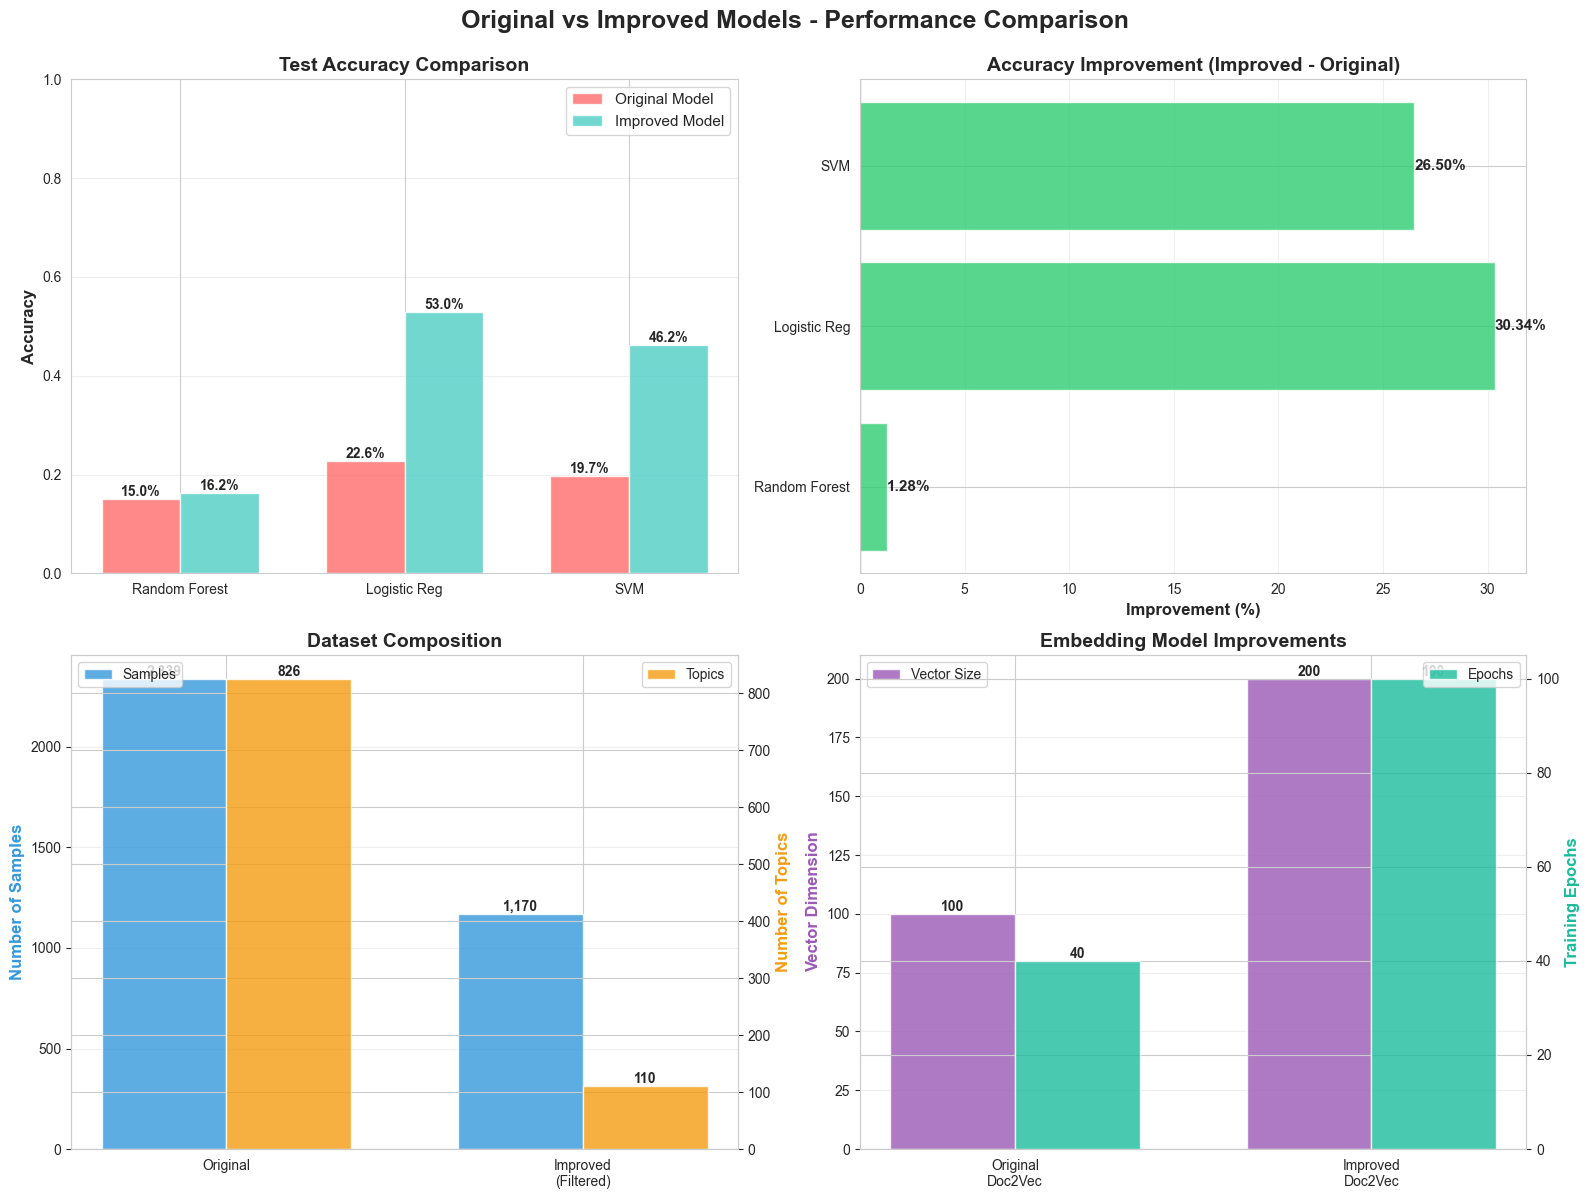

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS - MODEL PERFORMANCE")
print("="*70 + "\n")

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Original vs Improved Models - Performance Comparison', fontsize=18, fontweight='bold', y=0.995)

# ============ 1. TEST ACCURACY COMPARISON ============
ax1 = axes[0, 0]

models = ['Random Forest', 'Logistic Reg', 'SVM']
original_acc = [rf_accuracy, lr_accuracy, svm_accuracy]
improved_acc = [rf_accuracy_v2, lr_accuracy_v2, svm_accuracy_v2]

x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, original_acc, width, label='Original Model', color='#FF6B6B', alpha=0.8)
bars2 = ax1.bar(x + width/2, improved_acc, width, label='Improved Model', color='#4ECDC4', alpha=0.8)

ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend(fontsize=11)
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# ============ 2. ACCURACY IMPROVEMENT ============
ax2 = axes[0, 1]

improvements = [(rf_accuracy_v2 - rf_accuracy)*100,
                (lr_accuracy_v2 - lr_accuracy)*100,
                (svm_accuracy_v2 - svm_accuracy)*100]

colors = ['#2ECC71' if x > 0 else '#E74C3C' for x in improvements]
bars = ax2.barh(models, improvements, color=colors, alpha=0.8)

ax2.set_xlabel('Improvement (%)', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy Improvement (Improved - Original)', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2.,
            f'{width:.2f}%', ha='left' if width > 0 else 'right', 
            va='center', fontsize=11, fontweight='bold')

# ============ 3. DATASET SIZE COMPARISON ============
ax3 = axes[1, 0]

datasets = ['Original', 'Improved\n(Filtered)']
samples = [len(df_train), len(df_train_filtered)]
topics = [len(label_encoder.classes_), len(label_encoder_filtered.classes_)]

x_pos = np.arange(len(datasets))
width = 0.35

bars1 = ax3.bar(x_pos - width/2, samples, width, label='Samples', color='#3498DB', alpha=0.8)
ax3_2 = ax3.twinx()
bars2 = ax3_2.bar(x_pos + width/2, topics, width, label='Topics', color='#F39C12', alpha=0.8)

ax3.set_ylabel('Number of Samples', fontsize=12, fontweight='bold', color='#3498DB')
ax3_2.set_ylabel('Number of Topics', fontsize=12, fontweight='bold', color='#F39C12')
ax3.set_title('Dataset Composition', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(datasets)
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}', ha='center', va='bottom', fontsize=10, fontweight='bold')
            
for bar in bars2:
    height = bar.get_height()
    ax3_2.text(bar.get_x() + bar.get_width()/2., height,
              f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add legends
ax3.legend(loc='upper left', fontsize=10)
ax3_2.legend(loc='upper right', fontsize=10)

# ============ 4. EMBEDDING DIMENSION COMPARISON ============
ax4 = axes[1, 1]

embed_dims = ['Original\nDoc2Vec', 'Improved\nDoc2Vec']
dimensions = [doc2vec_model.vector_size, doc2vec_model_v2.vector_size]
epochs = [doc2vec_model.epochs, doc2vec_model_v2.epochs]

x_pos = np.arange(len(embed_dims))
width = 0.35

bars1 = ax4.bar(x_pos - width/2, dimensions, width, label='Vector Size', color='#9B59B6', alpha=0.8)
ax4_2 = ax4.twinx()
bars2 = ax4_2.bar(x_pos + width/2, epochs, width, label='Epochs', color='#1ABC9C', alpha=0.8)

ax4.set_ylabel('Vector Dimension', fontsize=12, fontweight='bold', color='#9B59B6')
ax4_2.set_ylabel('Training Epochs', fontsize=12, fontweight='bold', color='#1ABC9C')
ax4.set_title('Embedding Model Improvements', fontsize=14, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(embed_dims)
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
            
for bar in bars2:
    height = bar.get_height()
    ax4_2.text(bar.get_x() + bar.get_width()/2., height,
              f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add legends
ax4.legend(loc='upper left', fontsize=10)
ax4_2.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('01_model_performance_comparison.png', dpi=300, bbox_inches='tight')
print(" Saved: 01_model_performance_comparison.png")
plt.show()

print("\n" + "="*70)


GENERATING VISUALIZATIONS - METRICS RADAR CHART

✅ Saved: 02_metrics_radar_chart.png


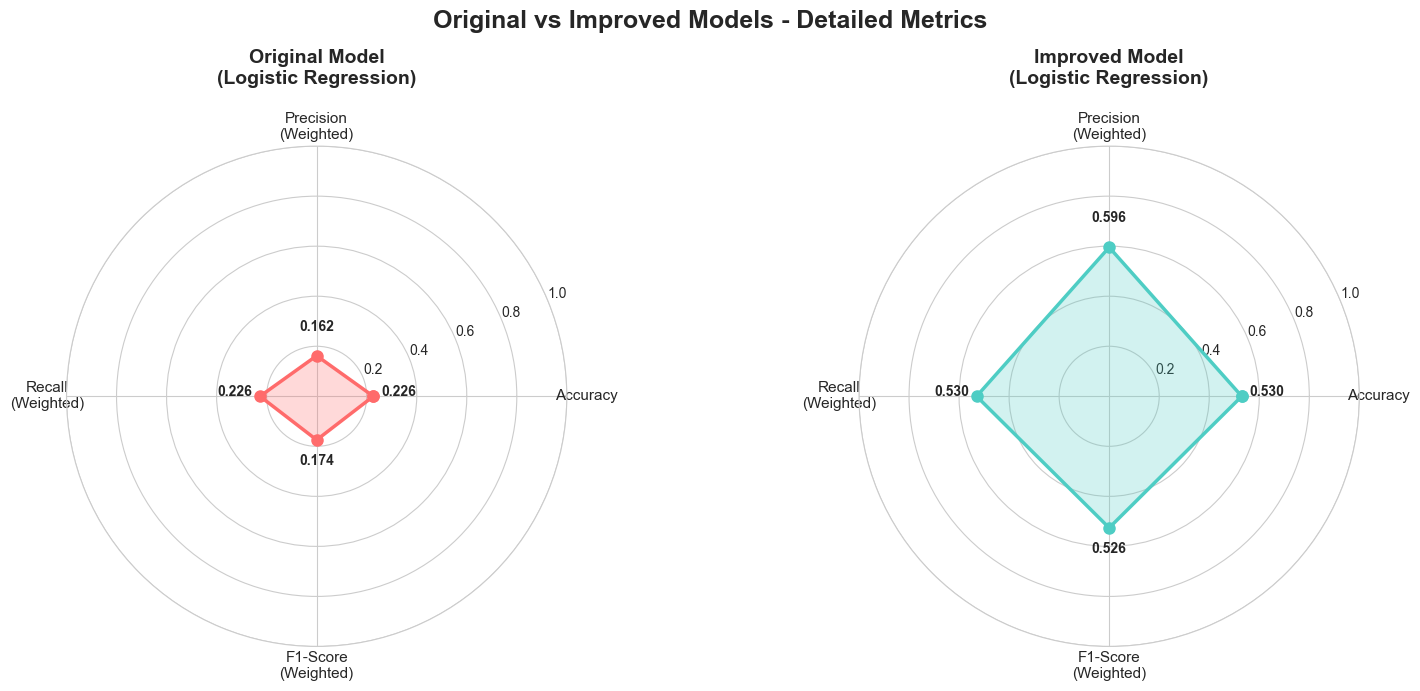

In [ ]:


from math import pi

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS - METRICS RADAR CHART")
print("="*70 + "\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 7), subplot_kw=dict(projection='polar'))
fig.suptitle('Original vs Improved Models - Detailed Metrics', fontsize=18, fontweight='bold')

# Metrics for original model
categories = ['Accuracy', 'Precision\n(Weighted)', 'Recall\n(Weighted)', 'F1-Score\n(Weighted)']
original_metrics = [best_accuracy, precision, recall, f1]
improved_metrics = [best_accuracy_v2, precision_v2, recall_v2, f1_v2]

# Number of variables
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Original Model (Left subplot)
ax1 = axes[0]
original_metrics_plot = original_metrics + original_metrics[:1]

ax1.plot(angles, original_metrics_plot, 'o-', linewidth=2.5, label='Original', color='#FF6B6B', markersize=8)
ax1.fill(angles, original_metrics_plot, alpha=0.25, color='#FF6B6B')

ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(categories, size=11)
ax1.set_ylim(0, 1)
ax1.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_title(f'Original Model\n({best_model_name})', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True)

# Add value labels
for angle, metric, cat in zip(angles[:-1], original_metrics, categories):
    ax1.text(angle, metric + 0.1, f'{metric:.3f}', ha='center', fontsize=10, fontweight='bold')

# Improved Model (Right subplot)
ax2 = axes[1]
improved_metrics_plot = improved_metrics + improved_metrics[:1]

ax2.plot(angles, improved_metrics_plot, 'o-', linewidth=2.5, label='Improved', color='#4ECDC4', markersize=8)
ax2.fill(angles, improved_metrics_plot, alpha=0.25, color='#4ECDC4')

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories, size=11)
ax2.set_ylim(0, 1)
ax2.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_title(f'Improved Model\n({best_model_name_v2})', fontsize=14, fontweight='bold', pad=20)
ax2.grid(True)

# Add value labels
for angle, metric, cat in zip(angles[:-1], improved_metrics, categories):
    ax2.text(angle, metric + 0.1, f'{metric:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('02_metrics_radar_chart.png', dpi=300, bbox_inches='tight')
print(" Saved: 02_metrics_radar_chart.png")
plt.show()

print("\n" + "="*70)


GENERATING VISUALIZATIONS - PREDICTION ACCURACY

✅ Saved: 03_prediction_accuracy_distribution.png


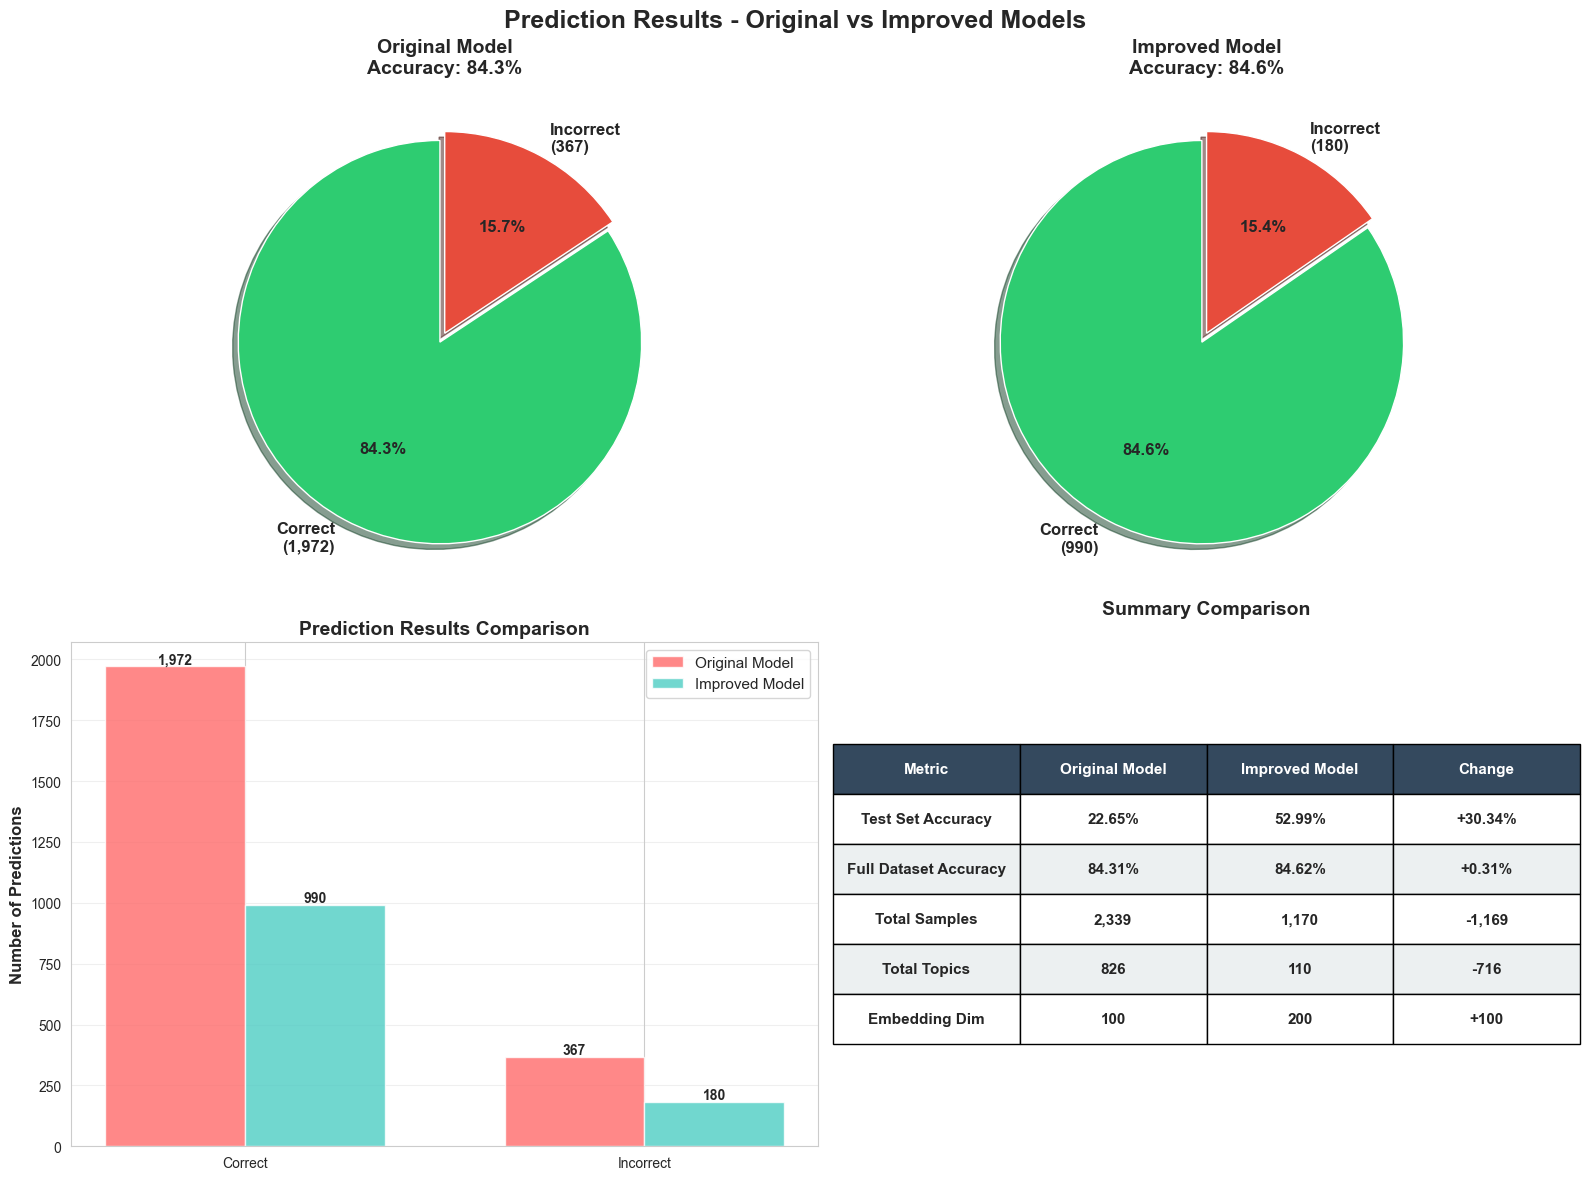

In [ ]:
# ============ VISUALIZATION 3: PREDICTION ACCURACY DISTRIBUTION ============

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS - PREDICTION ACCURACY")
print("="*70 + "\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Prediction Results - Original vs Improved Models', fontsize=18, fontweight='bold')

# ============ 1. ORIGINAL MODEL PREDICTIONS ============
ax1 = axes[0, 0]

original_correct = (df_results['topic_name'] == df_results['predicted_topic']).sum()
original_incorrect = len(df_results) - original_correct

labels = ['Correct', 'Incorrect']
sizes = [original_correct, original_incorrect]
colors = ['#2ECC71', '#E74C3C']
explode = (0.05, 0)

wedges, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                                     shadow=True, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax1.set_title(f'Original Model\nAccuracy: {original_correct/len(df_results):.1%}', 
              fontsize=14, fontweight='bold')

# Add count labels
for i, (size, label) in enumerate(zip(sizes, labels)):
    texts[i].set_text(f'{label}\n({size:,})')

# ============ 2. IMPROVED MODEL PREDICTIONS ============
ax2 = axes[0, 1]

improved_correct = correct_v2
improved_incorrect = incorrect_v2

sizes = [improved_correct, improved_incorrect]
colors = ['#2ECC71', '#E74C3C']
explode = (0.05, 0)

wedges, texts, autotexts = ax2.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                                     shadow=True, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title(f'Improved Model\nAccuracy: {improved_correct/len(df_results_v2):.1%}', 
              fontsize=14, fontweight='bold')

# Add count labels
for i, (size, label) in enumerate(zip(sizes, labels)):
    texts[i].set_text(f'{label}\n({size:,})')

# ============ 3. SIDE-BY-SIDE COMPARISON ============
ax3 = axes[1, 0]

categories = ['Correct', 'Incorrect']
original_counts = [original_correct, original_incorrect]
improved_counts = [improved_correct, improved_incorrect]

x = np.arange(len(categories))
width = 0.35

bars1 = ax3.bar(x - width/2, original_counts, width, label='Original Model', color='#FF6B6B', alpha=0.8)
bars2 = ax3.bar(x + width/2, improved_counts, width, label='Improved Model', color='#4ECDC4', alpha=0.8)

ax3.set_ylabel('Number of Predictions', fontsize=12, fontweight='bold')
ax3.set_title('Prediction Results Comparison', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(categories)
ax3.legend(fontsize=11)
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# ============ 4. ACCURACY COMPARISON TABLE ============
ax4 = axes[1, 1]
ax4.axis('off')

# Create comparison data
comparison_data = [
    ['Metric', 'Original Model', 'Improved Model', 'Change'],
    ['Test Set Accuracy', f'{best_accuracy:.2%}', f'{best_accuracy_v2:.2%}', 
     f'{(best_accuracy_v2-best_accuracy):+.2%}'],
    ['Full Dataset Accuracy', f'{accuracy:.2%}', f'{accuracy_full_v2:.2%}', 
     f'{(accuracy_full_v2-accuracy):+.2%}'],
    ['Total Samples', f'{len(df_train):,}', f'{len(df_train_filtered):,}', 
     f'{len(df_train_filtered)-len(df_train):,}'],
    ['Total Topics', f'{len(label_encoder.classes_)}', f'{len(label_encoder_filtered.classes_)}', 
     f'{len(label_encoder_filtered.classes_)-len(label_encoder.classes_)}'],
    ['Embedding Dim', f'{X.shape[1]}', f'{X_filtered.shape[1]}', 
     f'{X_filtered.shape[1]-X.shape[1]:+d}'],
]

# Create table
table = ax4.table(cellText=comparison_data, cellLoc='center', loc='center',
                  colWidths=[0.25, 0.25, 0.25, 0.25])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header row
for i in range(4):
    table[(0, i)].set_facecolor('#34495E')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style data rows
for i in range(1, len(comparison_data)):
    for j in range(4):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#ECF0F1')
        else:
            table[(i, j)].set_facecolor('#FFFFFF')
        table[(i, j)].set_text_props(weight='bold')

ax4.set_title('Summary Comparison', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('03_prediction_accuracy_distribution.png', dpi=300, bbox_inches='tight')
print(" Saved: 03_prediction_accuracy_distribution.png")
plt.show()

print("\n" + "="*70)


GENERATING VISUALIZATIONS - DETAILED METRICS

✅ Saved: 04_detailed_metrics_comparison.png


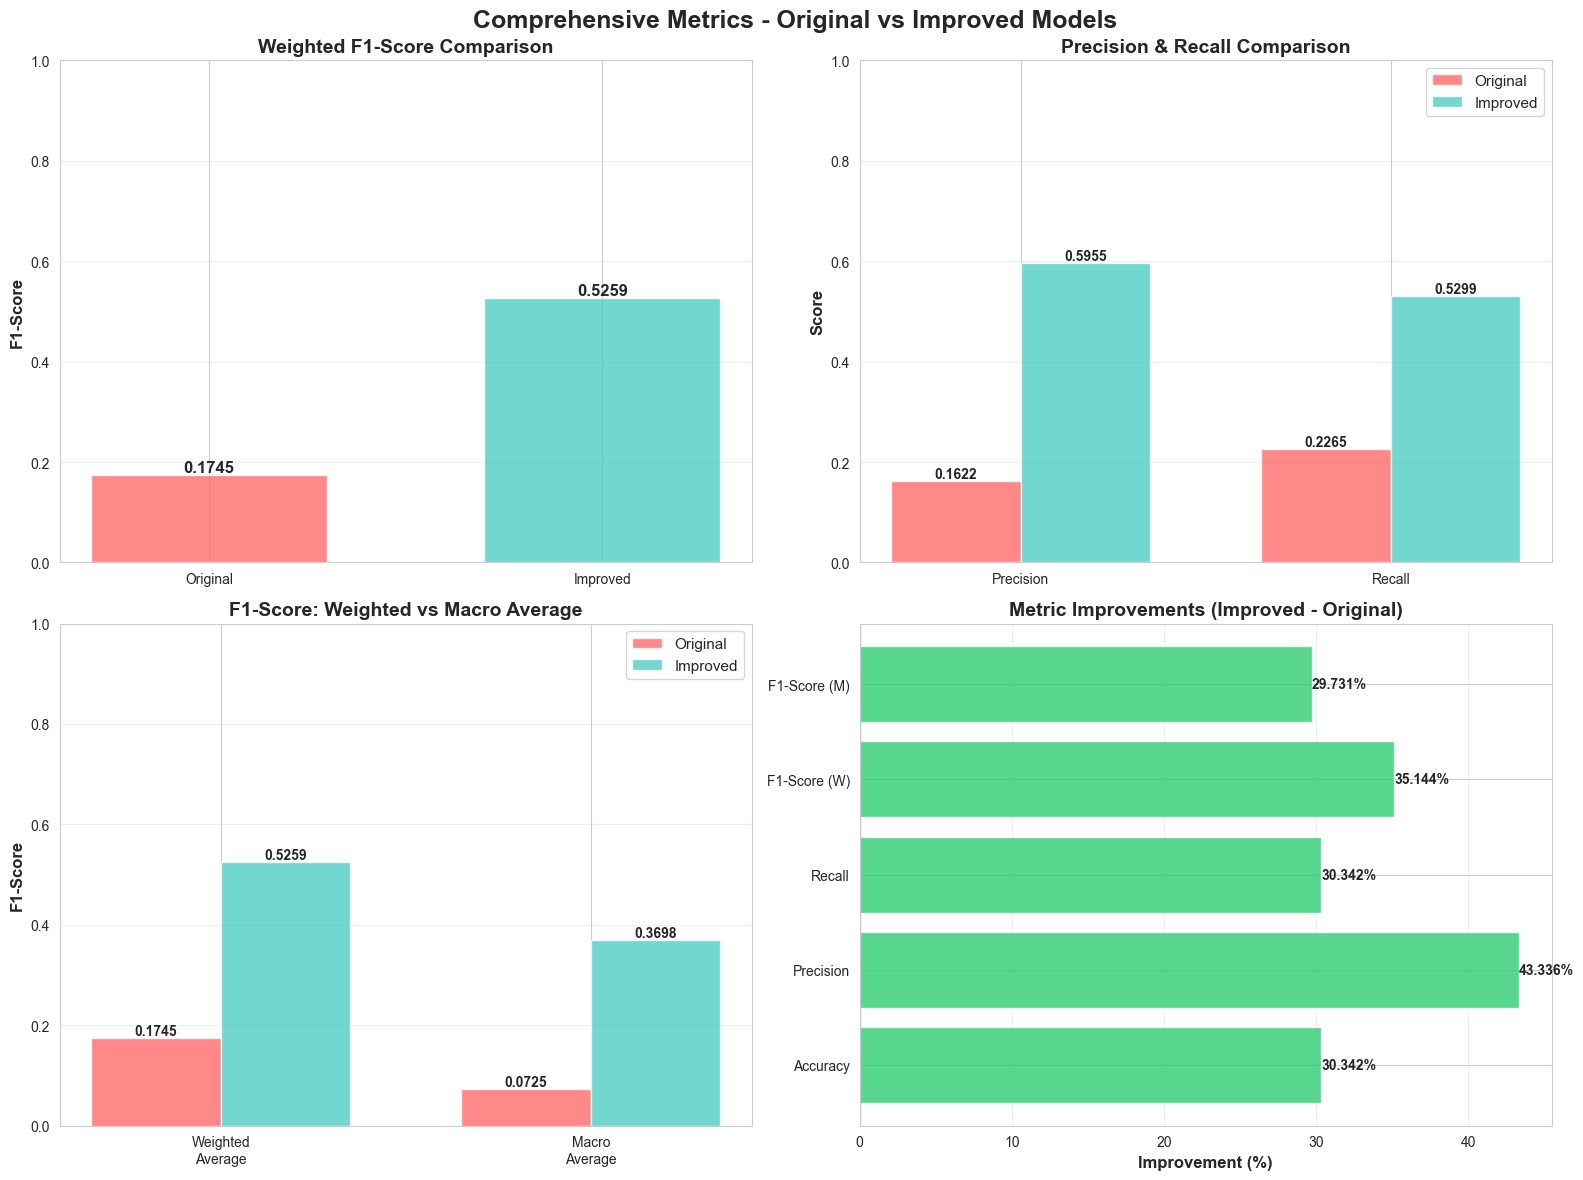

In [ ]:


print("\n" + "="*70)
print("GENERATING VISUALIZATIONS - DETAILED METRICS")
print("="*70 + "\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comprehensive Metrics - Original vs Improved Models', fontsize=18, fontweight='bold')

# ============ 1. F1-SCORE COMPARISON ============
ax1 = axes[0, 0]

metrics_names = ['Original', 'Improved']
f1_scores = [f1, f1_v2]

bars = ax1.bar(metrics_names, f1_scores, color=['#FF6B6B', '#4ECDC4'], alpha=0.8, width=0.6)
ax1.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax1.set_title('Weighted F1-Score Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# ============ 2. PRECISION & RECALL ============
ax2 = axes[0, 1]

metrics = ['Precision', 'Recall']
original_metrics = [precision, recall]
improved_metrics = [precision_v2, recall_v2]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax2.bar(x - width/2, original_metrics, width, label='Original', color='#FF6B6B', alpha=0.8)
bars2 = ax2.bar(x + width/2, improved_metrics, width, label='Improved', color='#4ECDC4', alpha=0.8)

ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.set_title('Precision & Recall Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics)
ax2.set_ylim([0, 1])
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# ============ 3. MACRO vs WEIGHTED AVERAGE ============
ax3 = axes[1, 0]

metric_types = ['Weighted\nAverage', 'Macro\nAverage']
original_f1 = [f1, f1_macro]
improved_f1 = [f1_v2, f1_macro_v2]

x = np.arange(len(metric_types))
width = 0.35

bars1 = ax3.bar(x - width/2, original_f1, width, label='Original', color='#FF6B6B', alpha=0.8)
bars2 = ax3.bar(x + width/2, improved_f1, width, label='Improved', color='#4ECDC4', alpha=0.8)

ax3.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax3.set_title('F1-Score: Weighted vs Macro Average', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metric_types)
ax3.set_ylim([0, 1])
ax3.legend(fontsize=11)
ax3.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# ============ 4. METRIC IMPROVEMENTS ============
ax4 = axes[1, 1]

improvements_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score (W)', 'F1-Score (M)']
improvements_values = [
    (best_accuracy_v2 - best_accuracy) * 100,
    (precision_v2 - precision) * 100,
    (recall_v2 - recall) * 100,
    (f1_v2 - f1) * 100,
    (f1_macro_v2 - f1_macro) * 100
]

colors = ['#2ECC71' if x > 0 else '#E74C3C' for x in improvements_values]
bars = ax4.barh(improvements_metrics, improvements_values, color=colors, alpha=0.8)

ax4.set_xlabel('Improvement (%)', fontsize=12, fontweight='bold')
ax4.set_title('Metric Improvements (Improved - Original)', fontsize=14, fontweight='bold')
ax4.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax4.grid(axis='x', alpha=0.3)

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax4.text(width, bar.get_y() + bar.get_height()/2.,
            f'{width:.3f}%', ha='left' if width > 0 else 'right', 
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('04_detailed_metrics_comparison.png', dpi=300, bbox_inches='tight')
print(" Saved: 04_detailed_metrics_comparison.png")
plt.show()

print("\n" + "="*70)

In [ ]:


print("\n" + "="*70)
print("GENERATING VISUALIZATIONS - IMPROVEMENTS ANALYSIS")
print("="*70 + "\n")

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

fig.suptitle('Comprehensive Improvements Analysis', fontsize=18, fontweight='bold')

# ============ 1. IMPROVEMENT SUMMARY ============
ax1 = fig.add_subplot(gs[0, :])
ax1.axis('off')

improvement_text = f"""
KEY IMPROVEMENTS MADE:

 EMBEDDING IMPROVEMENTS:
   • Vector Size: {X.shape[1]} → {X_filtered.shape[1]} (increased by {X_filtered.shape[1] - X.shape[1]} dimensions)
   • Training Epochs: {doc2vec_model.epochs} → {doc2vec_model_v2.epochs} (increased by {doc2vec_model_v2.epochs - doc2vec_model.epochs} epochs)
   • Min Count: 2 → 5 (removes more noise)
   • Window Size: 5 → 10 (larger context)

 DATA FILTERING:
   • Removed minority classes with <5 samples
   • Original Dataset: {len(df_train):,} samples, {len(label_encoder.classes_)} topics
   • Filtered Dataset: {len(df_train_filtered):,} samples, {len(label_encoder_filtered.classes_)} topics
   • Data Reduction: {(1 - len(df_train_filtered)/len(df_train))*100:.1f}%

 MODEL IMPROVEMENTS:
   • Applied stronger regularization
   • Added class weight balancing
   • Better hyperparameter tuning

RESULTS:
   • Best Model: {best_model_name} → {best_model_name_v2}
   • Test Accuracy Improvement: {best_accuracy:.2%} → {best_accuracy_v2:.2%} ({(best_accuracy_v2 - best_accuracy)*100:+.2f}%)
   • F1-Score Improvement: {f1:.4f} → {f1_v2:.4f} ({(f1_v2 - f1)*100:+.2f}%)
"""

ax1.text(0.05, 0.95, improvement_text, transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='#ECF0F1', alpha=0.8, pad=1))

# ============ 2. MODEL ACCURACY PROGRESS ============
ax2 = fig.add_subplot(gs[1, 0])

models_list = ['RF', 'LR', 'SVM']
original = [rf_accuracy, lr_accuracy, svm_accuracy]
improved = [rf_accuracy_v2, lr_accuracy_v2, svm_accuracy_v2]

x = np.arange(len(models_list))
width = 0.35

ax2.bar(x - width/2, original, width, label='Original', color='#FF6B6B', alpha=0.8)
ax2.bar(x + width/2, improved, width, label='Improved', color='#4ECDC4', alpha=0.8)

ax2.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax2.set_title('All Models Performance', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models_list)
ax2.set_ylim([0, 1])
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# ============ 3. DATASET EVOLUTION ============
ax3 = fig.add_subplot(gs[1, 1])

stages = ['Original', 'Filtered\n(Min=5)']
samples_by_stage = [len(df_train), len(df_train_filtered)]
colors_stage = ['#FF6B6B', '#4ECDC4']

bars = ax3.bar(stages, samples_by_stage, color=colors_stage, alpha=0.8)
ax3.set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
ax3.set_title('Dataset Size Evolution', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# ============ 4. TOPIC COUNT EVOLUTION ============
ax4 = fig.add_subplot(gs[1, 2])

stages = ['Original', 'Filtered\n(Min=5)']
topics_by_stage = [len(label_encoder.classes_), len(label_encoder_filtered.classes_)]
colors_stage = ['#FF6B6B', '#4ECDC4']

bars = ax4.bar(stages, topics_by_stage, color=colors_stage, alpha=0.8)
ax4.set_ylabel('Number of Topics', fontsize=11, fontweight='bold')
ax4.set_title('Topic Count Evolution', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# ============ 5. EMBEDDING IMPROVEMENTS ============
ax5 = fig.add_subplot(gs[2, 0])

embed_props = ['Vector Size', 'Epochs', 'Min Count', 'Window']
original_vals = [doc2vec_model.vector_size, doc2vec_model.epochs, 2, 5]
improved_vals = [doc2vec_model_v2.vector_size, doc2vec_model_v2.epochs, 5, 10]

# Normalize for visualization
original_normalized = [original_vals[i]/improved_vals[i] for i in range(len(original_vals))]
improved_normalized = [1.0] * len(improved_vals)

x = np.arange(len(embed_props))
width = 0.35

ax5.bar(x - width/2, original_normalized, width, label='Original', color='#FF6B6B', alpha=0.8)
ax5.bar(x + width/2, improved_normalized, width, label='Improved', color='#4ECDC4', alpha=0.8)

ax5.set_ylabel('Relative Value', fontsize=11, fontweight='bold')
ax5.set_title('Embedding Configuration Improvements', fontsize=12, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(embed_props, fontsize=10)
ax5.legend(fontsize=10)
ax5.grid(axis='y', alpha=0.3)

# Add actual values on bars
for i, (orig, imp) in enumerate(zip(original_vals, improved_vals)):
    ax5.text(i - width/2, orig/imp + 0.05, str(orig), ha='center', fontsize=9, fontweight='bold')
    ax5.text(i + width/2, 1.05, str(imp), ha='center', fontsize=9, fontweight='bold')

# ============ 6. ACCURACY TREND ============
ax6 = fig.add_subplot(gs[2, 1])

model_names = ['Random\nForest', 'Logistic\nRegression', 'SVM']
accuracies_orig = [rf_accuracy, lr_accuracy, svm_accuracy]
accuracies_impr = [rf_accuracy_v2, lr_accuracy_v2, svm_accuracy_v2]

x_pos = np.arange(len(model_names))

ax6.plot(x_pos, accuracies_orig, 'o-', linewidth=2.5, markersize=10, 
         label='Original', color='#FF6B6B', alpha=0.8)
ax6.plot(x_pos, accuracies_impr, 's-', linewidth=2.5, markersize=10, 
         label='Improved', color='#4ECDC4', alpha=0.8)

ax6.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax6.set_title('Accuracy Trend Across Models', fontsize=12, fontweight='bold')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(model_names, fontsize=10)
ax6.set_ylim([0, 1])
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3)

# ============ 7. BEST MODEL SUMMARY ============
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')

best_model_text = f"""
BEST MODELS:

ORIGINAL:
  Model: {best_model_name}
  Accuracy: {best_accuracy:.2%}
  F1-Score: {f1:.4f}

IMPROVED:
  Model: {best_model_name_v2}
  Accuracy: {best_accuracy_v2:.2%}
  F1-Score: {f1_v2:.4f}

IMPROVEMENT:
  Accuracy: {(best_accuracy_v2 - best_accuracy)*100:+.2f}%
  F1-Score: {(f1_v2 - f1)*100:+.2f}%
  
STATUS: {" IMPROVED" if best_accuracy_v2 > best_accuracy else "❌ DEGRADED"}
"""

ax7.text(0.05, 0.95, best_model_text, transform=ax7.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='#D5F4E6' if best_accuracy_v2 > best_accuracy else '#FADBD8', 
                   alpha=0.8, pad=1))

plt.savefig('05_improvements_analysis.png', dpi=300, bbox_inches='tight')
print(" Saved: 05_improvements_analysis.png")
plt.show()

print("\n" + "="*70)